In [2]:
# command to reload libraries
%load_ext autoreload
%autoreload 2

In [3]:
import warnings

from desReg.des.DESRegression import DESRegression
from desReg.utils import measures as em
from run_experiments import run_experiment_with_timeout, get_agg_results, get_df_results
from run_experiments import partitions_dict

import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy.spatial import distance
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message='The default value of `dual` will change')

/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
train_df_dict= {}
datasets = {}
for partition_alias, partition_name in partitions_dict.items():
    n_fold = 5
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for p in range(1,n_fold+1):
        name_train = partition_name+str(p)+'tra.dat'
        name_test = partition_name+str(p)+'tst.dat'

        data_train = pd.read_csv(name_train,header = None)
        columns = [f"V{i}" for i in range(data_train.shape[1] - 1)]
        columns.append("y")
        data_train.columns = columns
        X_train = data_train.iloc[:,:-1].to_numpy()
        y_train = np.ravel(data_train.iloc[:, -1:])

        data_test = pd.read_csv(name_test, header=None)
        data_test.columns = columns
        X_test = data_test.iloc[:,:-1].to_numpy()
        y_test = np.ravel(data_test.iloc[:, -1:])

        train_df = pd.concat([train_df, data_train], ignore_index=True)
        test_df = pd.concat([test_df, data_test], ignore_index=True)

    datasets[partition_alias] = dict(
        train_df = train_df,
        test_df = test_df
    )

## Calculate instance hardness


In [11]:
from desReg.utils import instance_hardness as ih

all_measures_dict = {}
for name, data in datasets.items():
    # if name in ["yacht"]:
    all_measures_dict[name] = dict()
    X_train = data['train_df'].drop(columns=['y'])
    y_train = data['train_df'][['y']]
    all_measures = ih.get_instance_hardness(X_train, y_train)
    all_hardness_measures = ih.get_hardness_measures(X_train, y_train)
    all_measures_dict[name]['instance_hardness'] = all_measures
    all_measures_dict[name]['hardness_measures'] = all_hardness_measures

/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

In [15]:

consolidated_df = dict()
for name in all_measures_dict.keys():
    consolidated_df[name] = ih.consolidate_data(
        all_measures_dict[name]['instance_hardness'], 
        all_measures_dict[name]['hardness_measures']
    )

In [37]:
from desReg.utils.instance_hardness import measures_dict

all_correlations = dict()

for name in consolidated_df.keys():
    all_correlations[name] = consolidated_df[name][['instance_hardness'] + list(measures_dict.keys())]\
        .corr()\
        [['instance_hardness']]\
        .T\
        .reset_index(drop=True)\
        .drop(columns=['instance_hardness'])\
        .assign(dataset=name)

In [39]:
# Iterate over all_correlations and concatenate all dataframes
all_correlations_df = pd.concat(all_correlations.values(), ignore_index=True)
all_correlations_df

C4        L1        S1        S2        S3        FO       POT  \
0  0.211943  0.886435  0.230678  0.109109  0.563641  0.021600  0.622130   
1  0.211595  0.858758  0.213091 -0.004702  0.142503  0.160602  0.196415   
2  0.319164  0.873805  0.089954  0.112994  0.402003  0.116084  0.337834   
3  0.180109  0.657242  0.424127 -0.047967  0.514392  0.497187  0.690639   
4  0.292783  0.819470 -0.025698 -0.068724  0.514338  0.108578  0.478555   
5  0.148170  0.640827  0.000870 -0.115575 -0.051480       NaN       NaN   
6  0.175595  0.883119  0.067382  0.114063  0.424723  0.075624  0.429923   
7  0.359316  0.872960  0.085150  0.038549  0.291000  0.035481  0.558218   
8  0.197278  0.648935  0.029837 -0.081754  0.785240  0.026675  0.882508   

         HB       EDS       EZR        DS      TD_P      TD_U         D  \
0  0.518005  0.710354  0.653120  0.043357  0.281279 -0.296072 -0.049367   
1  0.458022  0.273061  0.495159 -0.125569 -0.035813 -0.270670  0.264640   
2  0.094772  0.744229  0.789126       NaN -0.208508 -0.269613  0.165393   
3  0.482209  0.661058  0.724968 -0.304098 -0.388069 -0.559831  0.650461   
4  0.516048  0.636192  0.596090       NaN -0.122114 -0.344381  0.058137   
5  0.070553  0.209116  0.589668  0.438329 -0.004748  0.116700  0.402772   
6  0.660750  0.748547  0.326381       NaN -0.080151 -0.225205  0.092151   
7  0.730462  0.804791  0.659018       NaN -0.012327 -0.164839  0.118368   
8  0.449053  0.446458  0.888707 -0.274171  0.463392 -0.346341  0.201265   

         CC             dataset  
0 -0.089573             abalone  
1  0.268797            concrete  
2  0.089856               liver  
3  0.558587          machineCPU  
4  0.054812         real_estate  
5  0.401255       student_marks  
6  0.036330    wine_quality_red  
7  0.085976  wine_quality_white  
8  0.191544               yacht

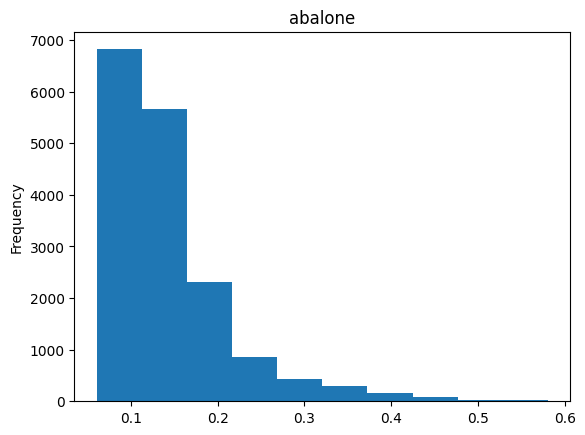

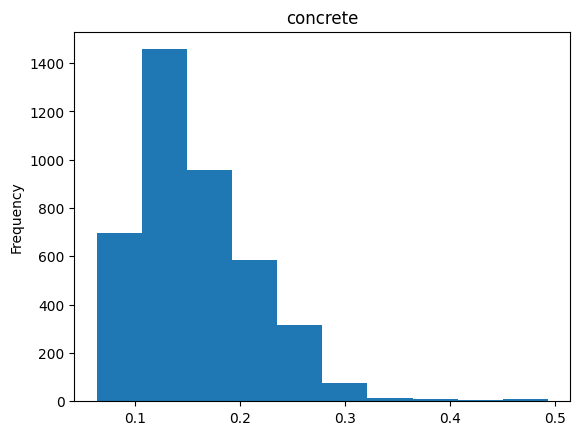

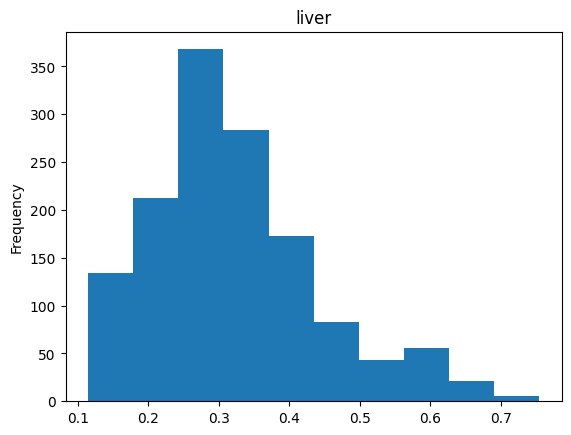

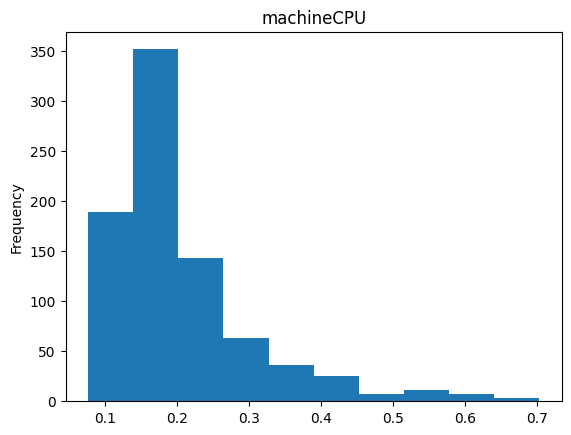

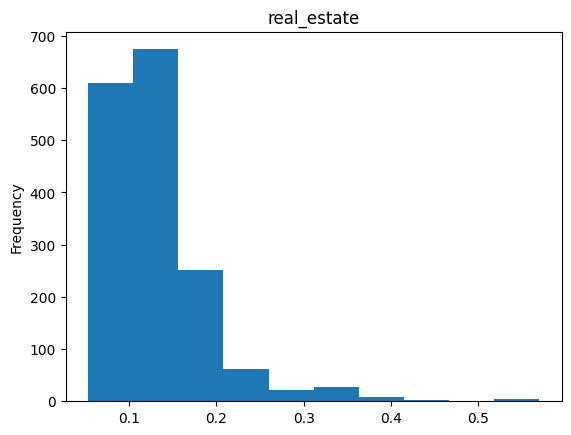

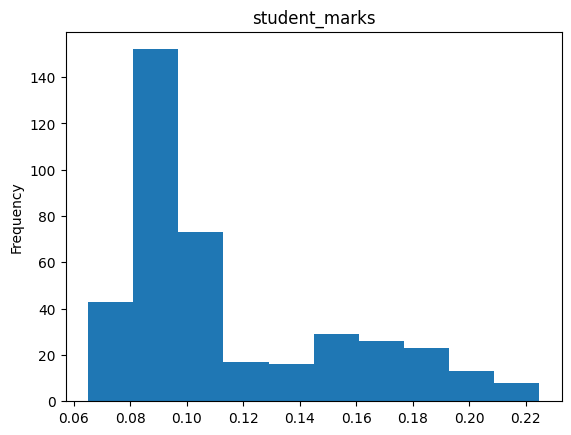

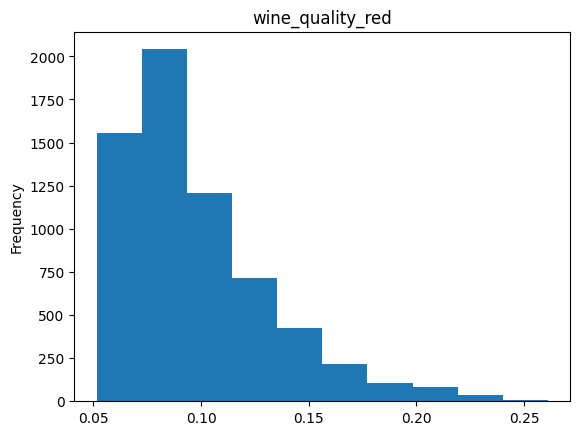

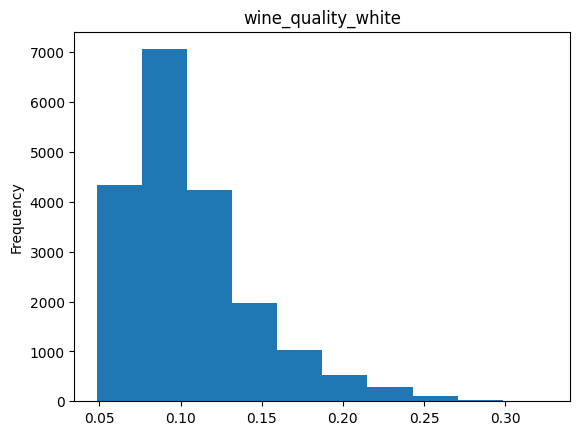

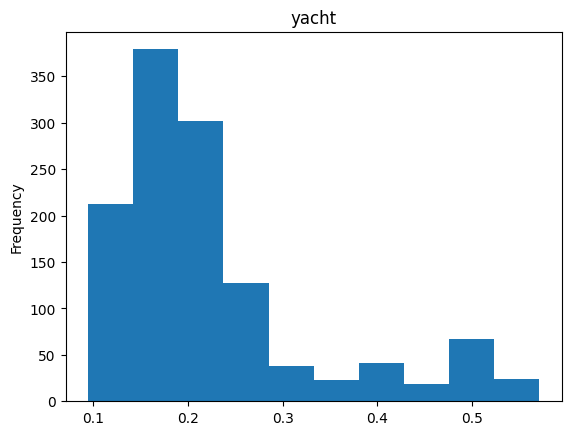

In [12]:
# plot instance hardness histogram
for name, all_measures in all_measures_dict.items():
    fig, ax = plt.subplots()
    all_measures['instance_hardness']['instance_hardness'].plot(kind='hist', ax=ax)
    ax.set_title(name)
    plt.show()


## Reproducing article results

In [8]:
regressors_list = [
    linear_model.Lasso(), 
    linear_model.Ridge(), 
    KNeighborsRegressor(), 
    SVR(), 
    DecisionTreeRegressor()
]

ensemble = DESRegression(
    regressors_list=regressors_list,
    random_state=0,
    n_estimators_bag=20,
    competence_region='knn',
    k=5,
    competence_level=em.all_errors,
    include_instance_hardness=False
)


article_results = run_experiment_with_timeout('yacht', baseline_model=ensemble, challenger_model={})

========== Processing yacht - Fold 1 ==========
Running baseline model...
========== Processing yacht - Fold 2 ==========
Running baseline model...
========== Processing yacht - Fold 3 ==========
Running baseline model...
========== Processing yacht - Fold 4 ==========
Running baseline model...
========== Processing yacht - Fold 5 ==========
Running baseline model...


In [9]:
article_results_df = get_df_results(article_results)
article_agg_results = get_agg_results(article_results_df)
article_agg_results

mse             r2             mae            rmse          \
              mean    std    mean     std    mean     std    mean     std   
model_name                                                                  
baseline    40.713  8.281  0.8225  0.0164  3.6823  0.2994  6.3541  0.6501   

              mape         execution_time                   
              mean     std           mean     std      sum  
model_name                                                  
baseline    2.6106  1.1027         3.6435  2.8094  18.2175

## Create ensembles

In [5]:
regressors_list = [
    linear_model.Lasso(), 
    linear_model.Ridge(), 
    KNeighborsRegressor(), 
    SVR(), 
    DecisionTreeRegressor()
]

ensemble = DESRegression(
    regressors_list=regressors_list,
    random_state=0,
    n_estimators_bag=20,
    competence_region='knn',
    k=5,
    competence_level=em.all_errors,
    include_instance_hardness=False
)

ensemble_ih = DESRegression(
    regressors_list = regressors_list,
    random_state=0,
    n_estimators_bag=20,
    competence_region='knn',
    k=5,
    competence_level=em.sum_absolute_error_weighted,
    include_instance_hardness=True,
    include_hardness_measures=False,
    hardness_measures_list=None,
    meta_feature='instance_hardness'
)

ensemble_hm = DESRegression(
    regressors_list = regressors_list,
    random_state=0,
    n_estimators_bag=20,
    competence_region='knn',
    k=5,
    competence_level=em.sum_absolute_error_weighted,
    include_instance_hardness=False,
    include_hardness_measures=True,
    hardness_measures_list=['S1', "S2", "S3", "D"],
    meta_feature='S2'
)

linear_reg = linear_model.LinearRegression()
challenger_experiments = {
    'ensemble_ih': {
        "model": ensemble_ih,
        "params": {
            "include_hardness_measures": False,
            "include_instance_hardness": True,
            "meta_feature": "instance_hardness"
        }
    },
    'ensemble_hm_s2': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "S2",
            "hardness_measures_list": ["S2"]
        }
    },
    'ensemble_hm_s1': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "S1",
            "hardness_measures_list": ["S1"]
        }
    },
    'ensemble_hm_s3': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "S3",
            "hardness_measures_list": ["S3"]
        }
    },
    'ensemble_hm_d': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "D",
            "hardness_measures_list": ["D"]
        }
    },
    'ensemble_hm_l1': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "L1",
            "hardness_measures_list": ["L1"]
        }
    },
    'ensemble_hm_ezr': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "EZR",
            "hardness_measures_list": ["EZR"]
        }
    },
    'ensemble_hm_eds': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "EDS",
            "hardness_measures_list": ["EDS"]
        }
    },
    'linear_reg': {
        "model": linear_reg,
    }
}

## yatch

In [8]:
yatch_results = run_experiment_with_timeout(
    'yacht', 
    baseline_model=ensemble, 
    challenger_experiments=challenger_experiments
)

========== Processing yacht - Fold 1 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/r

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing yacht - Fold 2 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing yacht - Fold 3 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing yacht - Fold 4 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing yacht - Fold 5 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...


In [9]:
yatch_results_df = get_df_results(yatch_results)
yatch_agg_results = get_agg_results(yatch_results_df)
yatch_agg_results

mse              r2             mae            rmse  \
                    mean     std    mean     std    mean     std    mean   
model_name                                                                 
baseline         40.7130  8.2810  0.8225  0.0164  3.6823  0.2994  6.3541   
ensemble_hm_d    26.4447  7.2186  0.8856  0.0190  2.9120  0.3554  5.1007   
ensemble_hm_eds  31.8687  4.7312  0.8593  0.0181  3.5551  0.1950  5.6334   
ensemble_hm_ezr  30.5003  5.1925  0.8661  0.0144  3.6048  0.2676  5.5075   
ensemble_hm_l1   18.2637  4.6606  0.9200  0.0157  2.4264  0.3623  4.2477   
ensemble_hm_s1   23.3294  3.5675  0.8972  0.0121  2.6476  0.3061  4.8194   
ensemble_hm_s2   26.4264  7.2864  0.8857  0.0194  2.9114  0.3525  5.0982   
ensemble_hm_s3   26.5157  1.8805  0.8826  0.0114  3.1715  0.0989  5.1467   
ensemble_ih      27.1979  7.0514  0.8811  0.0222  3.0764  0.2839  5.1833   
linear_reg       79.5926  9.6234  0.6496  0.0253  7.2047  0.2138  8.9085   

                            mape         execution_time                    
                    std     mean     std           mean     std       sum  
model_name                                                                 
baseline         0.6501   2.6106  1.1027         2.3378  0.0248   11.6892  
ensemble_hm_d    0.7308   2.1937  1.2102         8.3377  0.1235   41.6886  
ensemble_hm_eds  0.4078   2.0534  0.5397         8.3524  0.0773   41.7622  
ensemble_hm_ezr  0.4577   2.1065  0.7253         8.4011  0.1156   42.0057  
ensemble_hm_l1   0.5254   2.2641  1.4390         8.3767  0.0761   41.8836  
ensemble_hm_s1   0.3577   1.8349  0.7845         8.4388  0.0616   42.1942  
ensemble_hm_s2   0.7372   2.1919  1.2199         8.4417  0.0521   42.2083  
ensemble_hm_s3   0.1827   2.6269  1.4241         8.4406  0.1329   42.2028  
ensemble_ih      0.6434   2.1883  1.1591        62.4166  1.0043  312.0832  
linear_reg       0.5384  14.8792  7.0780         0.0006  0.0000    0.0031

## Student marks

In [10]:
student_marks_results = run_experiment_with_timeout(
    'student_marks', 
    baseline_model=ensemble, 
    challenger_experiments=challenger_experiments
)

========== Processing student_marks - Fold 1 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing student_marks - Fold 2 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing student_marks - Fold 3 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing student_marks - Fold 4 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing student_marks - Fold 5 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...


In [11]:
student_marks_results_df = get_df_results(student_marks_results)
student_marks_agg_results = get_agg_results(student_marks_results_df)

student_marks_agg_results

mse              r2             mae            rmse  \
                    mean     std    mean     std    mean     std    mean   
model_name                                                                 
baseline          2.3477  1.5707  0.9879  0.0074  1.0342  0.2900  1.4690   
ensemble_hm_d     1.7907  1.3455  0.9909  0.0064  0.9039  0.2790  1.2679   
ensemble_hm_eds   1.8909  1.1450  0.9902  0.0054  0.9652  0.2116  1.3292   
ensemble_hm_ezr   1.7611  1.3905  0.9911  0.0066  0.9115  0.3160  1.2485   
ensemble_hm_l1    1.7037  1.1658  0.9913  0.0054  0.9109  0.2585  1.2483   
ensemble_hm_s1    1.7892  1.3706  0.9908  0.0066  0.9156  0.2859  1.2652   
ensemble_hm_s2    1.7982  1.3588  0.9908  0.0065  0.9066  0.2883  1.2694   
ensemble_hm_s3    1.5976  1.2720  0.9919  0.0060  0.8483  0.3143  1.1856   
ensemble_ih       1.7317  1.3369  0.9912  0.0064  0.8932  0.2854  1.2423   
linear_reg       12.9917  2.0016  0.9296  0.0123  3.1464  0.3314  3.5964   

                           mape         execution_time                   
                    std    mean     std           mean     std      sum  
model_name                                                               
baseline         0.4871  0.0514  0.0119         0.7723  0.0133   3.8616  
ensemble_hm_d    0.4785  0.0444  0.0089         2.6285  0.0392  13.1427  
ensemble_hm_eds  0.3939  0.0455  0.0107         2.6605  0.1121  13.3025  
ensemble_hm_ezr  0.5029  0.0441  0.0091         2.6380  0.0399  13.1902  
ensemble_hm_l1   0.4262  0.0471  0.0118         2.6113  0.0524  13.0564  
ensemble_hm_s1   0.4852  0.0466  0.0101         2.6341  0.0246  13.1703  
ensemble_hm_s2   0.4832  0.0454  0.0087         2.6235  0.0567  13.1177  
ensemble_hm_s3   0.4897  0.0412  0.0081         2.6300  0.0515  13.1501  
ensemble_ih      0.4853  0.0442  0.0091        12.9216  0.1655  64.6081  
linear_reg       0.2681  0.1937  0.0377         0.0006  0.0001   0.0028

## Liver

In [12]:
liver_results = run_experiment_with_timeout(
    'liver', 
    baseline_model=ensemble, 
    challenger_experiments=challenger_experiments
)

========== Processing liver - Fold 1 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing liver - Fold 2 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing liver - Fold 3 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing liver - Fold 4 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing liver - Fold 5 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...


In [13]:
liver_results_df = get_df_results(liver_results)
liver_agg_results = get_agg_results(liver_results_df)
liver_agg_results

mse               r2               mae            rmse  \
                    mean     std     mean       std    mean     std    mean   
model_name                                                                    
baseline         12.3692  7.7322 -52.9900  110.5042  2.8684  0.8324  3.3675   
ensemble_hm_d    12.4894  7.4353 -55.3648  115.1815  2.8928  0.7963  3.3998   
ensemble_hm_eds  12.4804  6.9498 -56.1413  116.1447  2.8672  0.7575  3.4110   
ensemble_hm_ezr  11.8016  6.3644 -56.1119  116.7770  2.7771  0.7111  3.3226   
ensemble_hm_l1   12.8104  7.4803 -57.2588  118.7889  2.9108  0.7987  3.4462   
ensemble_hm_s1   12.5794  7.3700 -55.6684  115.6374  2.9105  0.7859  3.4155   
ensemble_hm_s2   12.6651  7.4896 -55.8490  116.0203  2.9114  0.7963  3.4250   
ensemble_hm_s3   12.7305  7.2562 -58.0512  120.2483  2.9018  0.7791  3.4391   
ensemble_ih      12.6866  7.3951 -57.0998  118.4925  2.9027  0.7916  3.4301   
linear_reg       12.0645  6.4937 -56.4142  117.7328  2.8015  0.7893  3.3642   

                                 mape               execution_time          \
                    std          mean           std           mean     std   
model_name                                                                   
baseline         1.1343  3.690752e+14  6.562521e+14         2.6242  0.0455   
ensemble_hm_d    1.0785  3.718503e+14  6.604863e+14         9.3170  0.0826   
ensemble_hm_eds  1.0279  3.761464e+14  6.676842e+14         9.3440  0.1018   
ensemble_hm_ezr  0.9757  3.749028e+14  6.615906e+14         9.3510  0.1006   
ensemble_hm_l1   1.0806  3.715912e+14  6.643109e+14         9.3600  0.1237   
ensemble_hm_s1   1.0689  3.700391e+14  6.558373e+14         9.4989  0.1250   
ensemble_hm_s2   1.0806  3.698392e+14  6.563736e+14         9.4232  0.0985   
ensemble_hm_s3   1.0625  3.745206e+14  6.746496e+14         9.3834  0.1010   
ensemble_ih      1.0730  3.774291e+14  6.711632e+14        75.9387  2.1651   
linear_reg       0.9663  3.626094e+14  6.117064e+14         0.0006  0.0000   

                           
                      sum  
model_name                 
baseline          13.1210  
ensemble_hm_d     46.5850  
ensemble_hm_eds   46.7200  
ensemble_hm_ezr   46.7549  
ensemble_hm_l1    46.8001  
ensemble_hm_s1    47.4944  
ensemble_hm_s2    47.1158  
ensemble_hm_s3    46.9170  
ensemble_ih      379.6936  
linear_reg         0.0030

## real_estate

In [14]:
real_estate_results = run_experiment_with_timeout(
    'real_estate', 
    baseline_model=ensemble, 
    challenger_experiments=challenger_experiments
)

========== Processing real_estate - Fold 1 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing real_estate - Fold 2 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing real_estate - Fold 3 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing real_estate - Fold 4 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing real_estate - Fold 5 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...


In [15]:
real_estate_results_df = get_df_results(real_estate_results)
real_estate_agg_results = get_agg_results(real_estate_results_df)
real_estate_agg_results

mse               r2             mae            rmse  \
                    mean      std    mean     std    mean     std    mean   
model_name                                                                  
baseline         45.3153  17.5081  0.7359  0.0925  4.6971  0.9423  6.6133   
ensemble_hm_d    48.2603  20.2131  0.7153  0.1231  4.6478  1.0579  6.7936   
ensemble_hm_eds  44.8096  17.1825  0.7382  0.0931  4.7135  0.9285  6.5751   
ensemble_hm_ezr  44.0071  17.5390  0.7429  0.0952  4.6777  0.9820  6.5089   
ensemble_hm_l1   44.6261  17.8513  0.7389  0.0985  4.6935  1.0091  6.5452   
ensemble_hm_s1   47.4189  19.3659  0.7208  0.1152  4.6432  1.0526  6.7405   
ensemble_hm_s2   47.9957  20.6507  0.7168  0.1257  4.6233  1.1006  6.7646   
ensemble_hm_s3   43.8289  17.9880  0.7438  0.0986  4.6205  1.0392  6.4769   
ensemble_ih      44.2043  18.7006  0.7415  0.1029  4.6338  1.0675  6.4996   
linear_reg       62.6112  14.9619  0.6338  0.0737  5.7106  0.6940  7.8720   

                           mape         execution_time                    
                    std    mean     std           mean     std       sum  
model_name                                                                
baseline         1.4050  0.1387  0.0389         3.2777  0.0089   16.3886  
ensemble_hm_d    1.6228  0.1362  0.0420        12.0734  0.0612   60.3669  
ensemble_hm_eds  1.4042  0.1402  0.0390        12.0776  0.0617   60.3879  
ensemble_hm_ezr  1.4325  0.1367  0.0415        12.0979  0.0650   60.4893  
ensemble_hm_l1   1.4946  0.1383  0.0404        12.0818  0.0520   60.4089  
ensemble_hm_s1   1.5749  0.1361  0.0423        12.2318  0.0749   61.1591  
ensemble_hm_s2   1.6721  0.1356  0.0430        12.1227  0.0764   60.6136  
ensemble_hm_s3   1.5323  0.1346  0.0425        12.1449  0.1142   60.7243  
ensemble_ih      1.5650  0.1361  0.0430       106.0352  0.5651  530.1758  
linear_reg       0.8964  0.1758  0.0319         0.0006  0.0000    0.0032

## machineCPU

In [16]:
machine_cpu_results = run_experiment_with_timeout(
    'machineCPU', 
    baseline_model=ensemble, 
    challenger_experiments=challenger_experiments
)

========== Processing machineCPU - Fold 1 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing machineCPU - Fold 2 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing machineCPU - Fold 3 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing machineCPU - Fold 4 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing machineCPU - Fold 5 ==========
Running baseline model...


desReg.des.DESRegression - INFO - Calculating instance hardness for instance_hardness


Running challenger model: ensemble_ih...


/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/victor.nunes/Documents/Github/regression-instance-hardness/.venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:

Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...


In [17]:
machine_cpu_results_df = get_df_results(machine_cpu_results)
machine_cpu_agg_results = get_agg_results(machine_cpu_results_df)
machine_cpu_agg_results

mse                 r2              mae          \
                      mean        std    mean     std     mean     std   
model_name                                                               
baseline         3396.8046  2725.4175  0.8790  0.0547  28.7158  7.1063   
ensemble_hm_d    3240.4710  2420.5627  0.8855  0.0421  28.7539  6.3218   
ensemble_hm_eds  3342.2723  2593.0839  0.8831  0.0486  28.4025  6.4841   
ensemble_hm_ezr  3236.5212  2455.6157  0.8852  0.0433  28.8318  6.0793   
ensemble_hm_l1   3264.1527  2554.9877  0.8855  0.0463  29.0420  6.5188   
ensemble_hm_s1   3244.6209  2452.3376  0.8851  0.0426  28.2886  5.8344   
ensemble_hm_s2   3252.0792  2420.6689  0.8848  0.0421  28.7028  6.2251   
ensemble_hm_s3   3238.1148  2463.4500  0.8859  0.0432  28.9274  6.5615   
ensemble_ih      3296.8251  2502.2437  0.8830  0.0444  28.9369  6.5088   
linear_reg       4320.9630  2485.3003  0.8274  0.0759  40.0855  6.4918   

                    rmse             mape         execution_time          \
                    mean      std    mean     std           mean     std   
model_name                                                                 
baseline         54.5657  22.8962  0.3684  0.0243         1.6681  0.0262   
ensemble_hm_d    53.6909  21.1470  0.3629  0.0364         5.6641  0.0757   
ensemble_hm_eds  54.1832  22.5402  0.3515  0.0350         5.6934  0.1246   
ensemble_hm_ezr  53.6853  21.0478  0.3657  0.0403         5.6545  0.0555   
ensemble_hm_l1   53.6546  21.9469  0.3903  0.0344         5.6669  0.0545   
ensemble_hm_s1   53.7282  21.1513  0.3641  0.0393         5.6804  0.0722   
ensemble_hm_s2   53.8115  21.1070  0.3742  0.0252         5.6660  0.0862   
ensemble_hm_s3   53.5995  21.3662  0.3750  0.0423         5.6538  0.0456   
ensemble_ih      54.1464  21.3599  0.3847  0.0269        30.7371  0.5635   
linear_reg       63.3809  19.4878  0.7654  0.0394         0.0006  0.0000   

                           
                      sum  
model_name                 
baseline           8.3403  
ensemble_hm_d     28.3207  
ensemble_hm_eds   28.4672  
ensemble_hm_ezr   28.2725  
ensemble_hm_l1    28.3346  
ensemble_hm_s1    28.4021  
ensemble_hm_s2    28.3299  
ensemble_hm_s3    28.2692  
ensemble_ih      153.6856  
linear_reg         0.0030

## abalone (6h p/ rodar)

In [18]:
linear_reg = linear_model.LinearRegression()
challenger_experiments_without_ih = {
    'ensemble_hm_s2': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "S2",
            "hardness_measures_list": ["S2"]
        }
    },
    'ensemble_hm_s1': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "S1",
            "hardness_measures_list": ["S1"]
        }
    },
    'ensemble_hm_s3': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "S3",
            "hardness_measures_list": ["S3"]
        }
    },
    'ensemble_hm_d': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "D",
            "hardness_measures_list": ["D"]
        }
    },
    'ensemble_hm_l1': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "L1",
            "hardness_measures_list": ["L1"]
        }
    },
    'ensemble_hm_ezr': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "EZR",
            "hardness_measures_list": ["EZR"]
        }
    },
    'ensemble_hm_eds': {
        "model": ensemble_hm,
        "params": {
            "include_hardness_measures": True,
            "include_instance_hardness": False,
            "meta_feature": "EDS",
            "hardness_measures_list": ["EDS"]
        }
    },
    'linear_reg': {
        "model": linear_reg,
    }
}

In [19]:
abalone_results = run_experiment_with_timeout(
    'abalone', 
    baseline_model=ensemble, 
    challenger_experiments=challenger_experiments_without_ih
)

========== Processing abalone - Fold 1 ==========
Running baseline model...
Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing abalone - Fold 2 ==========
Running baseline model...
Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing abalone - Fold 3 ==========
Running baseline model...
Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing abalone - Fold 4 ==========
Running baseline model...
Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...
========== Processing abalone - Fold 5 ==========
Running baseline model...
Running challenger model: ensemble_hm_s2...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S2']
desReg.des.DESRegression - INFO - Selected hardness measure S2
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S1']
desReg.des.DESRegression - INFO - Selected hardness measure S1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_s3...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - Calculating hardness measures for ['S3']
desReg.des.DESRegression - INFO - Selected hardness measure S3
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_d...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating hardness measures for ['D']
desReg.des.DESRegression - INFO - Selected hardness measure D
desReg.des.DESRegression - INFO - Calculating ha

Running challenger model: ensemble_hm_l1...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - Calculating hardness measures for ['L1']
desReg.des.DESRegression - INFO - Selected hardness measure L1
desReg.des.DESRegression - INFO - 

Running challenger model: ensemble_hm_ezr...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EZR']
desReg.des.DESRegression - INFO - Selected hardness measure EZR
desReg.des.DESRegres

Running challenger model: ensemble_hm_eds...


desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegression - INFO - Calculating hardness measures for ['EDS']
desReg.des.DESRegression - INFO - Selected hardness measure EDS
desReg.des.DESRegres

Running challenger model: linear_reg...


In [21]:
abalone_results_df = get_df_results(abalone_results)
abalone_agg_results = get_agg_results(abalone_results_df)
abalone_agg_results

mse              r2             mae            rmse  \
                   mean     std    mean     std    mean     std    mean   
model_name                                                                
baseline         4.7228  0.4447  0.5454  0.0087  1.5065  0.0563  2.1713   
ensemble_hm_d    4.6857  0.4024  0.5488  0.0037  1.5082  0.0542  2.1631   
ensemble_hm_eds  4.6590  0.3921  0.5513  0.0069  1.5304  0.0628  2.1570   
ensemble_hm_ezr  4.5884  0.3860  0.5581  0.0049  1.5217  0.0549  2.1406   
ensemble_hm_l1   4.7617  0.4562  0.5418  0.0074  1.5232  0.0618  2.1802   
ensemble_hm_s1   4.7195  0.4224  0.5456  0.0073  1.5142  0.0557  2.1707   
ensemble_hm_s2   4.6801  0.4089  0.5494  0.0038  1.5094  0.0531  2.1617   
ensemble_hm_s3   4.7667  0.4644  0.5413  0.0067  1.5484  0.0659  2.1812   
linear_reg       4.9423  0.4954  0.5240  0.0263  1.5920  0.0573  2.2209   

                           mape         execution_time                      
                    std    mean     std           mean      std        sum  
model_name                                                                  
baseline         0.1018  0.1479  0.0040        54.6644   0.5903   273.3222  
ensemble_hm_d    0.0922  0.1487  0.0044       435.5998  10.9604  2177.9989  
ensemble_hm_eds  0.0901  0.1530  0.0056       436.6034  13.4293  2183.0171  
ensemble_hm_ezr  0.0891  0.1515  0.0045       436.7606  11.0819  2183.8032  
ensemble_hm_l1   0.1038  0.1507  0.0051       515.1860  16.3693  2575.9298  
ensemble_hm_s1   0.0967  0.1493  0.0045       929.4144  41.5702  4647.0721  
ensemble_hm_s2   0.0937  0.1490  0.0044       433.9309   7.7478  2169.6543  
ensemble_hm_s3   0.1052  0.1552  0.0057       454.6061   4.7061  2273.0307  
linear_reg       0.1107  0.1605  0.0044         0.0009   0.0001     0.0046

## wine_white (6h e nao terminou)

In [ ]:
wine_quality_white_results = run_experiment_with_timeout(
    'wine_quality_white', 
    baseline_model=ensemble, 
    challenger_model=challenger_models
)


In [ ]:

wine_quality_white_results_df = get_df_results(wine_quality_white_results)
wine_quality_white_agg_results = get_agg_results(wine_quality_white_results_df)
wine_quality_white_agg_results

## wine_red

## All results

In [22]:
all_results = pd.concat([
    yatch_results_df.assign(dataset='yacht'),
    student_marks_results_df.assign(dataset='student_marks'),
    liver_results_df.assign(dataset='liver'),
    real_estate_results_df.assign(dataset='real_estate'),
    machine_cpu_results_df.assign(dataset='machine_cpu'),
    abalone_results_df.assign(dataset='abalone'),
], ignore_index=True)

all_results.groupby(['dataset', 'model_name']).agg({
    'mse': ['mean', 'std'],
    'r2': ['mean', 'std'],
    'mae': ['mean', 'std'],
    'rmse': ['mean', 'std'],
    'mape': ['mean', 'std'],
    'execution_time': ['mean', 'std', 'sum']
}).round(4)

mse                  r2            \
                                    mean        std     mean       std   
dataset       model_name                                                 
abalone       baseline            4.7228     0.4447   0.5454    0.0087   
              ensemble_hm_d       4.6857     0.4024   0.5488    0.0037   
              ensemble_hm_eds     4.6590     0.3921   0.5513    0.0069   
              ensemble_hm_ezr     4.5884     0.3860   0.5581    0.0049   
              ensemble_hm_l1      4.7617     0.4562   0.5418    0.0074   
              ensemble_hm_s1      4.7195     0.4224   0.5456    0.0073   
              ensemble_hm_s2      4.6801     0.4089   0.5494    0.0038   
              ensemble_hm_s3      4.7667     0.4644   0.5413    0.0067   
              linear_reg          4.9423     0.4954   0.5240    0.0263   
liver         baseline           12.3692     7.7322 -52.9900  110.5042   
              ensemble_hm_d      12.4894     7.4353 -55.3648  115.1815   
              ensemble_hm_eds    12.4804     6.9498 -56.1413  116.1447   
              ensemble_hm_ezr    11.8016     6.3644 -56.1119  116.7770   
              ensemble_hm_l1     12.8104     7.4803 -57.2588  118.7889   
              ensemble_hm_s1     12.5794     7.3700 -55.6684  115.6374   
              ensemble_hm_s2     12.6651     7.4896 -55.8490  116.0203   
              ensemble_hm_s3     12.7305     7.2562 -58.0512  120.2483   
              ensemble_ih        12.6866     7.3951 -57.0998  118.4925   
              linear_reg         12.0645     6.4937 -56.4142  117.7328   
machine_cpu   baseline         3396.8046  2725.4175   0.8790    0.0547   
              ensemble_hm_d    3240.4710  2420.5627   0.8855    0.0421   
              ensemble_hm_eds  3342.2723  2593.0839   0.8831    0.0486   
              ensemble_hm_ezr  3236.5212  2455.6157   0.8852    0.0433   
              ensemble_hm_l1   3264.1527  2554.9877   0.8855    0.0463   
              ensemble_hm_s1   3244.6209  2452.3376   0.8851    0.0426   
              ensemble_hm_s2   3252.0792  2420.6689   0.8848    0.0421   
              ensemble_hm_s3   3238.1148  2463.4500   0.8859    0.0432   
              ensemble_ih      3296.8251  2502.2437   0.8830    0.0444   
              linear_reg       4320.9630  2485.3003   0.8274    0.0759   
real_estate   baseline           45.3153    17.5081   0.7359    0.0925   
              ensemble_hm_d      48.2603    20.2131   0.7153    0.1231   
              ensemble_hm_eds    44.8096    17.1825   0.7382    0.0931   
              ensemble_hm_ezr    44.0071    17.5390   0.7429    0.0952   
              ensemble_hm_l1     44.6261    17.8513   0.7389    0.0985   
              ensemble_hm_s1     47.4189    19.3659   0.7208    0.1152   
              ensemble_hm_s2     47.9957    20.6507   0.7168    0.1257   
              ensemble_hm_s3     43.8289    17.9880   0.7438    0.0986   
              ensemble_ih        44.2043    18.7006   0.7415    0.1029   
              linear_reg         62.6112    14.9619   0.6338    0.0737   
student_marks baseline            2.3477     1.5707   0.9879    0.0074   
              ensemble_hm_d       1.7907     1.3455   0.9909    0.0064   
              ensemble_hm_eds     1.8909     1.1450   0.9902    0.0054   
              ensemble_hm_ezr     1.7611     1.3905   0.9911    0.0066   
              ensemble_hm_l1      1.7037     1.1658   0.9913    0.0054   
              ensemble_hm_s1      1.7892     1.3706   0.9908    0.0066   
              ensemble_hm_s2      1.7982     1.3588   0.9908    0.0065   
              ensemble_hm_s3      1.5976     1.2720   0.9919    0.0060   
              ensemble_ih         1.7317     1.3369   0.9912    0.0064   
              linear_reg         12.9917     2.0016   0.9296    0.0123   
yacht         baseline           40.7130     8.2810   0.8225    0.0164   
              ensemble_hm_d      26.4447     7.2186   0.8856    0.0190   
              ensemble_hm_eds    31.8687 

In [24]:

# Save results
timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
all_results.to_csv(f'detailed_results_{timestamp}.csv', index=False)

## Graveyard

In [68]:
# # Run experiments for all datasets
# for dataset in partitions_dict.keys():
#     try:
#         results = run_experiment(dataset)
#     except Exception as e:
#         print(f"Error processing {dataset}: {str(e)}")

In [69]:
# # Calculate summary statistics
# summary = results.groupby(['dataset', 'method']).agg({
#     'mse': ['mean', 'std'],
#     'r2': ['mean', 'std'],
#     'mae': ['mean', 'std'],
#     'rmse': ['mean', 'std'],
#     'mape': ['mean', 'std']
# }).round(4)

# # Save results
# timestamp = dt.datetime.now().strftime('%Y%m%d_%H%M%S')
# # results.to_csv(f'detailed_results_{timestamp}.csv', index=False)
# # summary.to_csv(f'summary_results_{timestamp}.csv')

In [20]:
# results = pd.read_csv("detailed_results_20250413_012125.csv")
# summary = results.groupby(['Dataset', 'Method']).agg({
#     'MSE': ['mean', 'std'],
#     'R2': ['mean', 'std'],
#     'MAE': ['mean', 'std'],
#     'RMSE': ['mean', 'std'],
#     'MAPE': ['mean', 'std']
# }).round(4)
# # Print summary table
# print("\n=== Summary Results ===")
# display(summary)


=== Summary Results ===


MSE              R2             MAE          \
                           mean     std    mean     std    mean     std   
Dataset          Method                                                   
wine_quality_red DES     0.4663  0.0298  0.2842  0.0512  0.4690  0.0176   
                 DES_IH  0.6401  0.0780  0.0165  0.1324  0.5022  0.0194   
                 Linear  0.4234  0.0282  0.3498  0.0504  0.5037  0.0241   

                           RMSE            MAPE          
                           mean     std    mean     std  
Dataset          Method                                  
wine_quality_red DES     0.6826  0.0220  0.0866  0.0030  
                 DES_IH  0.7989  0.0485  0.0921  0.0037  
                 Linear  0.6504  0.0219  0.0923  0.0043